In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint
from scipy.stats import rv_histogram, norm

import src
from src.reload import deep_reload

In [2]:
deep_reload(src)

arrival_rate = 1 / (10 * 60)
service_rate = 1 / (45 * 60)
servicers = 5

waiting_time = src.queuing.mmc_queue(arrival_rate, service_rate, servicers)
waiting_time

4117.463391957859

In [3]:
deep_reload(src)

rho = .5
service_rate = 1 / (45 * 60)
servicers = 5

arrival_rate = rho * servicers * service_rate

waiting_time = src.queuing.mmc_queue(arrival_rate, service_rate, servicers)
waiting_time, arrival_rate

(140.8010012515645, 0.0009259259259259259)

In [34]:
deep_reload(src)

servicers = list(range(1, 16))
rho = np.linspace(0, .99, 100)
service_rate = 1 / (30 * 60)
max_time = np.inf

waiting_time = np.zeros((len(servicers), len(rho)))

for idx_0 in range(len(servicers)):
    for idx_1 in range(len(rho)):

        arrival_rate = rho[idx_1] * servicers[idx_0] * service_rate

        waiting_time[idx_0, idx_1] = src.queuing.mmc_queue(
            arrival_rate, service_rate, servicers[idx_0], max_time = max_time
        )

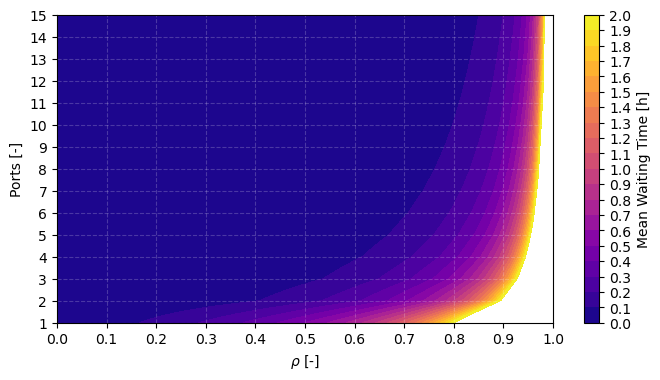

In [62]:
xg, yg = np.meshgrid(rho, servicers, indexing = 'ij')

fig, ax = plt.subplots(1, 1, figsize = (8, 4))

# cmap = src.figures.colormap(["#000000", "xkcd:cyan"])
# cmap = src.figures.colormap(["#ffffff", "#000000"])
# cmap = src.figures.colormap(["xkcd:black", "xkcd:green"])
cmap = src.figures.colormap("plasma")
# cmap = src.figures.colormap(["#000000", "#ffffff"])

c = ax.contourf(
    xg, yg, waiting_time.T / 3600,
    levels = np.linspace(0, 2, 21),
    cmap = cmap,
)

# c = ax.contour(
#     xg, yg, waiting_time.T / 3600,
#     levels = np.linspace(0, 5, 21),
#     colors = '#ffffff', linewidths = .5,
# )

plt.colorbar(
    ax = ax, mappable = c,
    ticks = np.linspace(0, 2, 21),
    label = 'Mean Waiting Time [h]',
    # extend = 'max',
    # extendfrac = .5,
)

kw = {
    'xticks': np.linspace(0, 1, 11),
    'yticks': servicers,
    'xlabel': r'$\rho$ [-]',
    'ylabel': 'Ports [-]',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'color': 'w',
    'alpha': .2,
}

_ = ax.grid(**kw)

fig.savefig('Paper/figs/waiting_time_rho_ports.png', bbox_inches = 'tight', dpi = 300)

In [27]:
deep_reload(src)

rho = np.linspace(.0, .33, 100)
# rho = np.linspace(.33, .66, 100)
# rho = np.linspace(.66, .99, 100)
# rho = np.linspace(0, 1, 100)

max_time = np.inf
servicers = list(range(1, 16))

service_rate = 1 / np.clip(norm(30 * 60, 10 * 60).ppf(rho), 1, np.inf)

waiting_time_data = np.zeros((len(servicers), len(rho)))

for idx_0 in range(len(servicers)):
    
    waiting_time = np.zeros(len(rho))
    
    for idx_1 in range(len(rho)):

        arrival_rate = rho[idx_1] * servicers[idx_0] * service_rate[idx_1]

        waiting_time[idx_1] = src.queuing.mmc_queue(
            arrival_rate, service_rate[idx_1], servicers[idx_0], max_time = max_time
        )

    waiting_time_data[idx_0] = waiting_time

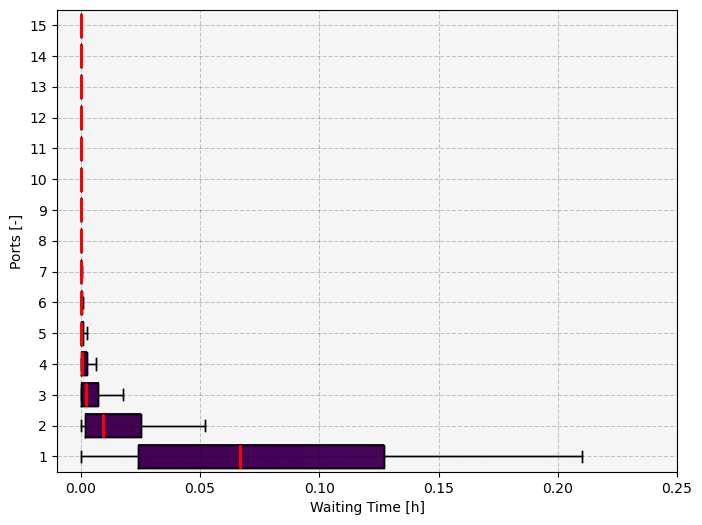

In [28]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

kw = {
    'vert': False,
    'showfliers': False,
    'widths': .75,
    'medianprops': {
        'lw': 2,
        'color': 'r'
    },
}

boxplots = ax.boxplot(waiting_time_data.T  / 3600, **kw)

for box in boxplots['boxes']:

    x, y = box.get_xydata().T

    gradient = np.atleast_2d(np.linspace(min(x), max(x), 1000))

    ax.imshow(
            gradient,
            # cmap = cmap,
            extent=[min(x), max(x), min(y) , max(y)],
            aspect="auto",
            # zorder = 3,
            vmin = 0,
            vmax = 8,
        )

boxplots = ax.boxplot(waiting_time_data.T  / 3600, **kw)

kw = {
    'yticks': servicers,
    'xlabel': 'Waiting Time [h]',
    'ylabel': 'Ports [-]',
    'facecolor': 'whitesmoke',
    'xlim': (-.01, .25)
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'color': 'k',
    'alpha': .2,
}

_ = ax.grid(**kw)

# _ = ax.legend()

fig.savefig('Paper/figs/waiting_time_aggressive.png', bbox_inches = 'tight', dpi = 300)

In [29]:
deep_reload(src)

# rho = np.linspace(.0, .33, 100)
rho = np.linspace(.33, .66, 100)
# rho = np.linspace(.66, .99, 100)
# rho = np.linspace(0, 1, 100)

max_time = np.inf
servicers = list(range(1, 16))

service_rate = 1 / np.clip(norm(30 * 60, 10 * 60).ppf(rho), 1, np.inf)

waiting_time_data = np.zeros((len(servicers), len(rho)))

for idx_0 in range(len(servicers)):
    
    waiting_time = np.zeros(len(rho))
    
    for idx_1 in range(len(rho)):

        arrival_rate = rho[idx_1] * servicers[idx_0] * service_rate[idx_1]

        waiting_time[idx_1] = src.queuing.mmc_queue(
            arrival_rate, service_rate[idx_1], servicers[idx_0], max_time = max_time
        )

    waiting_time_data[idx_0] = waiting_time

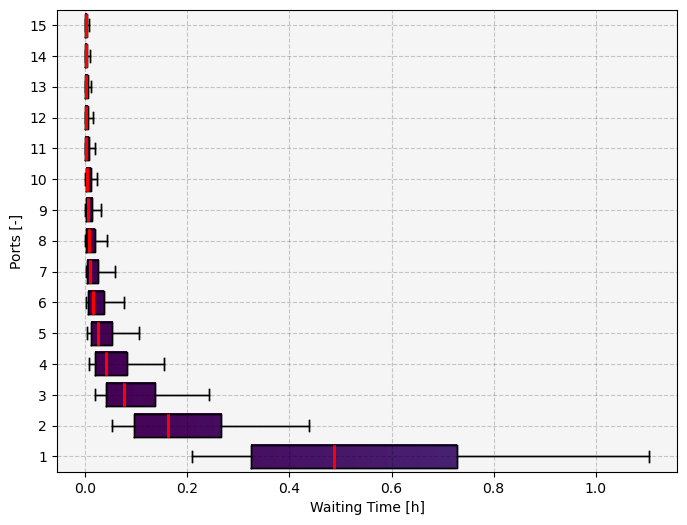

In [30]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

kw = {
    'vert': False,
    'showfliers': False,
    'widths': .75,
    'medianprops': {
        'lw': 2,
        'color': 'r'
    },
}

boxplots = ax.boxplot(waiting_time_data.T  / 3600, **kw)

for box in boxplots['boxes']:

    x, y = box.get_xydata().T

    gradient = np.atleast_2d(np.linspace(min(x), max(x), 1000))

    ax.imshow(
            gradient,
            # cmap = cmap,
            extent=[min(x), max(x), min(y) , max(y)],
            aspect="auto",
            # zorder = 3,
            vmin = 0,
            vmax = 8,
        )

boxplots = ax.boxplot(waiting_time_data.T  / 3600, **kw)

kw = {
    'yticks': servicers,
    'xlabel': 'Waiting Time [h]',
    'ylabel': 'Ports [-]',
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'color': 'k',
    'alpha': .2,
}

_ = ax.grid(**kw)

# _ = ax.legend()

fig.savefig('Paper/figs/waiting_time_neutral.png', bbox_inches = 'tight', dpi = 300)

In [31]:
deep_reload(src)

# rho = np.linspace(.0, .33, 100)
# rho = np.linspace(.33, .66, 100)
rho = np.linspace(.66, .99, 100)
# rho = np.linspace(0, 1, 100)

max_time = np.inf
servicers = list(range(1, 16))

service_rate = 1 / np.clip(norm(30 * 60, 10 * 60).ppf(rho), 1, np.inf)

waiting_time_data = np.zeros((len(servicers), len(rho)))

for idx_0 in range(len(servicers)):
    
    waiting_time = np.zeros(len(rho))
    
    for idx_1 in range(len(rho)):

        arrival_rate = rho[idx_1] * servicers[idx_0] * service_rate[idx_1]

        waiting_time[idx_1] = src.queuing.mmc_queue(
            arrival_rate, service_rate[idx_1], servicers[idx_0], max_time = max_time
        )

    waiting_time_data[idx_0] = waiting_time

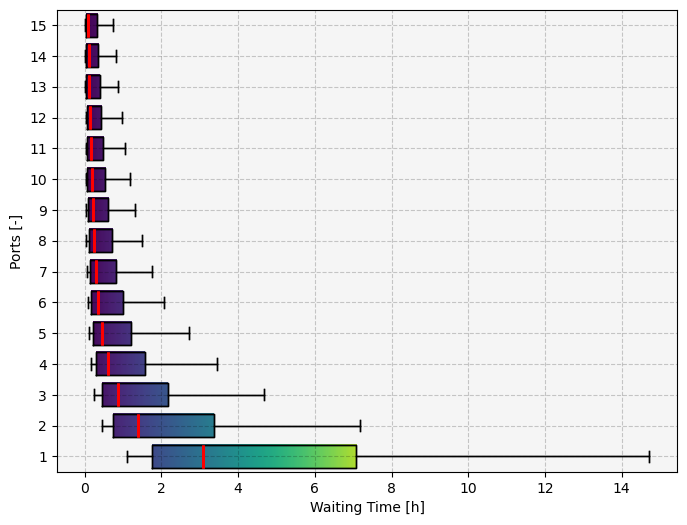

In [32]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

kw = {
    'vert': False,
    'showfliers': False,
    'widths': .75,
    'medianprops': {
        'lw': 2,
        'color': 'r'
    },
}

boxplots = ax.boxplot(waiting_time_data.T  / 3600, **kw)

for box in boxplots['boxes']:

    x, y = box.get_xydata().T

    gradient = np.atleast_2d(np.linspace(min(x), max(x), 1000))

    ax.imshow(
            gradient,
            # cmap = cmap,
            extent=[min(x), max(x), min(y) , max(y)],
            aspect="auto",
            # zorder = 3,
            vmin = 0,
            vmax = 8,
        )

boxplots = ax.boxplot(waiting_time_data.T  / 3600, **kw)

kw = {
    'yticks': servicers,
    'xlabel': 'Waiting Time [h]',
    'ylabel': 'Ports [-]',
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'color': 'k',
    'alpha': .2,
}

_ = ax.grid(**kw)

# _ = ax.legend()

fig.savefig('Paper/figs/waiting_time_cautious.png', bbox_inches = 'tight', dpi = 300)

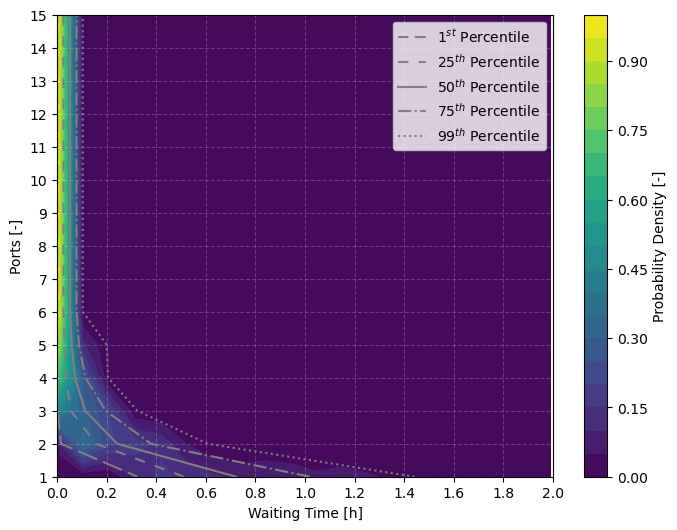

In [274]:
deep_reload(src)

xg, yg = np.meshgrid(bins[:-1] / 3600, servicers, indexing = 'ij')

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

c = ax.contourf(
    xg, yg, waiting_time_hist.T * (bins[1] - bins[0]),
    levels = 21,
    # cmap = src.figures.colormap('ice', reverse = True),
    cmap = src.figures.colormap('viridis', reverse = True),
)

kw = {
    'lw': 1.5,
    'color': 'gray',
}

ax.plot(
    waiting_time_expected[:, 0] / 3600, servicers,
    label = r'$1^{st}$ Percentile', ls = (5, (10, 3)), **kw,
)
ax.plot(
    waiting_time_expected[:, 1] / 3600, servicers,
    label = r'$25^{th}$ Percentile', ls = (0, (5, 5)), **kw,
)

ax.plot(
    waiting_time_expected[:, 2] / 3600, servicers,
    label = r'$50^{th}$ Percentile', ls = '-', **kw,
)

ax.plot(
    waiting_time_expected[:, 3] / 3600, servicers,
    label = r'$75^{th}$ Percentile', ls ='-.', **kw,
)

ax.plot(
    waiting_time_expected[:, 4] / 3600, servicers,
    label = r'$99^{th}$ Percentile', ls = 'dotted', **kw,
)

plt.colorbar(
    ax = ax, mappable = c,
    label = 'Probability Density [-]',
    extend = 'max',
    extendfrac = .5,
)

kw = {
    'xticks': np.linspace(0, 2, 11),
    'yticks': servicers,
    'xlabel': 'Waiting Time [h]',
    'ylabel': 'Ports [-]',
    'xlim': (0, 2),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'color': 'w',
    'alpha': .2,
}

_ = ax.grid(**kw)

_ = ax.legend()

In [5]:
deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

servers = 2
server_kw = {
    'rng': rng,
    'service_rate': lambda rng: rng.choice([80]) * 1e3, # [W]
}

servers = [src.queuing.Server(**server_kw) for idx in range(servers)]

demand_kw = {
    'rng': rng,
    'max_length': 5,
    'inter_arrival': lambda rng: rng.exponential(600), # [Bool]
    'capacity': lambda rng: rng.normal(45, 0) * 3.6e6, # [J]
}

demand = src.queuing.Demand(**demand_kw)

system = src.queuing.System(servers, demand)

queue, served, status = system.simulate(steps = 10 * 3600, step = 60)

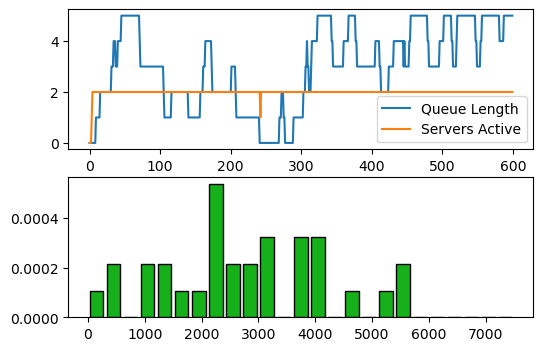

In [6]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(2, 1, figsize = (6, 4))

ax[0].plot(status['in_queue'], label = 'Queue Length')
ax[0].plot(status['in_service'], label = 'Servers Active')

ax[0].legend()

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(0, 7800, 300)),
    'density': True,
}

_ = ax[1].hist(steps, **kw)

In [7]:
deep_reload(src)

qt = []

for idx in range(100):

    kw = {
        'n': 5,
        'server': {
            'rng': rng,
            'service_rate': lambda rng: rng.choice([80]) * 1e3, # [W]
        },
        'demand': {
            'rng': rng,
            'inter_arrival': lambda rng: rng.exponential(600), # [Bool]
            'capacity': lambda rng: rng.normal(45, 0) * 3.6e6, # [J]
        },
        'simulation': {
            'steps': 10 * 3600,
            'step': 60,
        },
        'histogram': {
            'bins': list(range(0, 3600 * 10, 6)),
        },
    }

    qtd = src.queuing.queuing_time_distribution(**kw)
    qt.extend(list(qtd.rvs(size = 1000)))

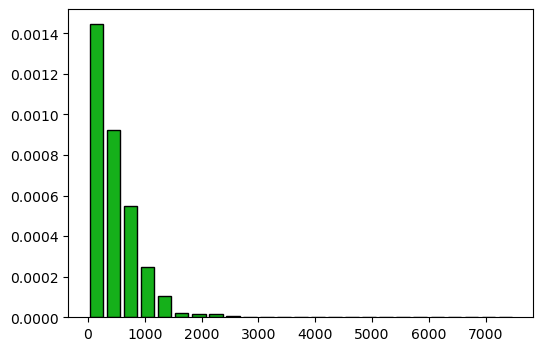

In [8]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(0, 7800, 300)),
    'density': True,
}

_ = ax.hist(qt, **kw)

In [9]:
qtd.rvs(size = 10)

array([1134.24171086,  116.19367108, 1135.67814675, 1136.74924076,
        774.40550363,  594.12214644,  597.9362728 ,  595.91709934,
       1139.94378847,  777.66662569])

In [10]:
deep_reload(src)

def qt_run(n, m, bins, iterations = 100):

    qt = []
    
    for idx in range(iterations):
    
        kw = {
            'n': n,
            'server': {
                'rng': rng,
                'service_rate': lambda rng: rng.choice([80]) * 1e3, # [W]
            },
            'demand': {
                'rng': rng,
                'max_length': 10,
                'initial': rng.integers(0, n + 1),
                'inter_arrival': lambda rng: rng.exponential(m), # [Bool]
                'capacity': lambda rng: rng.normal(45, 0) * 3.6e6, # [J]
            },
            'simulation': {
                'steps': 10 * 3600,
                'step': 60,
            },
            'histogram': {
                'bins': bins,
            },
        }
    
        qtd = src.queuing.queuing_time_distribution(**kw)
        qt.append(qtd.mean())

    return qt

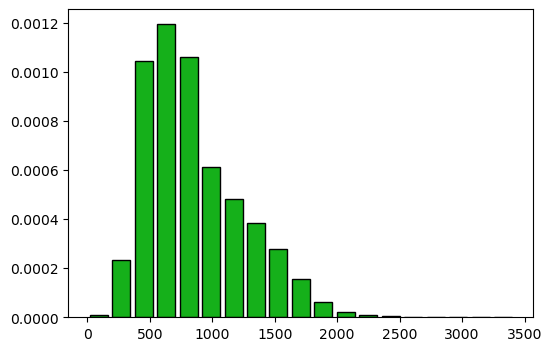

In [19]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(0, 3600, 180)),
    'density': True,
}

_ = ax.hist(qt_run(4, 600, kw['bins'], iterations = 1000), **kw)

In [426]:
chargers = list(range(1, 15))
inter_arrival = 5
bins = list(range(60, 3600, 300))

values = []

for n in src.progress_bar.ProgressBar(chargers):

    val, _ = np.histogram(qt_run(n, inter_arrival, bins), bins = bins, density = True)
    values.append(val)

 [------------->] (14/14) 100.00%, 3.30 it/s, 4.54 s elapsed, 0.00 s remaining

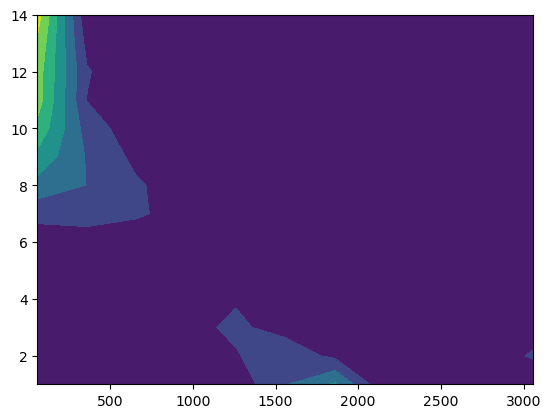

In [427]:
cg, bg = np.meshgrid(chargers, bins[:-1], indexing = 'ij')

plt.contourf(bg, cg, values)

In [425]:
values[0], values[-1]

(array([8.19000000e-05, 5.94666667e-05, 9.04666667e-05, 2.21966667e-04,
        2.84366667e-04, 7.34833333e-04, 8.40866667e-04, 1.47566667e-04,
        2.02433333e-04, 3.16333333e-04, 3.53133333e-04]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]))

In [446]:
deep_reload(src)

def qt_run(servers, service_time, rho, bins):

    arrival_rate = rho * servers * (1 / service_time)
    print(arrival_rate)

    qt = []
    
    for idx in range(100):
    
        kw = {
            'n': servers,
            'server': {
                'rng': rng,
                'service_rate': lambda rng: 1, # [W]
            },
            'demand': {
                'rng': rng,
                'spawn_criteria': lambda rng: rng.random() <= arrival_rate,
                'capacity': lambda rng: service_time, # [J]
            },
            'simulation': {
                'steps': 1440,
                'step': 1,
            },
            'histogram': {
                'bins': bins,
            },
        }
    
        qtd = src.queuing.queuing_time_distribution(**kw)
        qt.extend(list(qtd.rvs(size = 1000)))

    return qt

0.13333333333333333


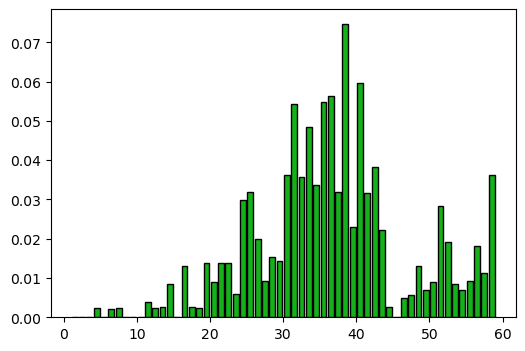

In [447]:
steps = np.array([customer.steps - customer.steps_service for customer in served])

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    'rwidth': .8,
    'ec': 'k',
    'fc': 'xkcd:green',
    'bins': list(range(1, 60, 1)),
    'density': True,
}

_ = ax.hist(qt_run(2, 45, 3, kw['bins']), **kw)